<a href="https://colab.research.google.com/github/aaronjoel/DeepUnderstandingOfDeepLearning/blob/main/FFN_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import copy

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

import seaborn as sns

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# z-score all columns
data = (data - data.mean()) / data.std(ddof=1)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy(data)

In [ ]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan
# (note: in the video I don't have replace=False, which means it's possible to select the same value twice)
whichVals2nan = np.random.choice(range(len(data)), size=n2nan, replace=False)

whichVals2nan

array([ 853, 1569,  109,  239,  662,  248,  727,  927, 1264, 1391])

In [ ]:
# set those values to be nan (ignore the overwrite warning)
data['residual sugar'][whichVals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]
whichValsNotNan

array([   0,    1,    2, ..., 1596, 1597, 1598])

In [ ]:
# confirm
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 109  239  248  662  727  853  927 1264 1391 1569]
[ 109  239  248  662  727  853  927 1264 1391 1569]


In [ ]:
# convrt from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
cols2keep = cols2keep.drop('residual sugar')
cols2keep

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
# extract dataframe to TRAIN tensors
train_dataT = torch.tensor(data[cols2keep].values).float()
train_dataT = train_dataT[whichValsNotNan, :]
train_labelT= torch.tensor(data['residual sugar'].values).float()
train_labelT = train_labelT[whichValsNotNan, None]  # the None is transform to matrix


# same for TEST tensors
test_dataT = torch.tensor(dataOrig[cols2keep].values).float()
test_dataT = test_dataT[whichVals2nan, :]
test_labelT= torch.tensor(dataOrig['residual sugar'].values).float()
test_labelT = test_labelT[whichVals2nan, None]  # the None is transform to matrix

In [ ]:
# confirm sizes
print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelT.shape}')

Original data: (1599, 12)

   Train data: torch.Size([1589, 11])

 Train labels: torch.Size([1589, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [ ]:
test_labelT

tensor([[-0.7368],
        [-0.4531],
        [-0.3822],
        [-0.1694],
        [-0.6659],
        [-0.5949],
        [-0.5240],
        [-0.2403],
        [-0.5240],
        [-0.0984]])

In [ ]:
# the convert them into PyTorch Dataset
train_dataDataset = TensorDataset(train_dataT, train_labelT)

# finally, translate into dataloader objects
batch_size = 32
train_dataLoader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class ANNWine(nn.Module):

  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(11, 16)

    # hidden layers
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # output layer
    self.output = nn.Linear(32, 1)

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.output(x)

In [ ]:
# global parameter
num_epochs = 400

def trainTheModel(model, train_data, lr=0.1, num_epochs=num_epochs):

  # loss function and optimizer
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)

  # initialize losses
  trainLoss = torch.zeros(num_epochs)

  # loop over epochs
  for epoch in range(num_epochs):
    # loop over training data batches
    batchLoss = []
    for X, y in train_data:

      # forward pass and loss
      yhat = model(X)
      loss = loss_fn(yhat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # get average losses across the batches
    trainLoss[epoch] = np.mean(batchLoss)

  # function output
  return trainLoss

In [ ]:
wine_net = ANNWine()
trainLoss = trainTheModel(wine_net, train_dataLoader)

In [ ]:
yhatTrain = wine_net(train_dataT)
yhatTest = wine_net(test_dataT)

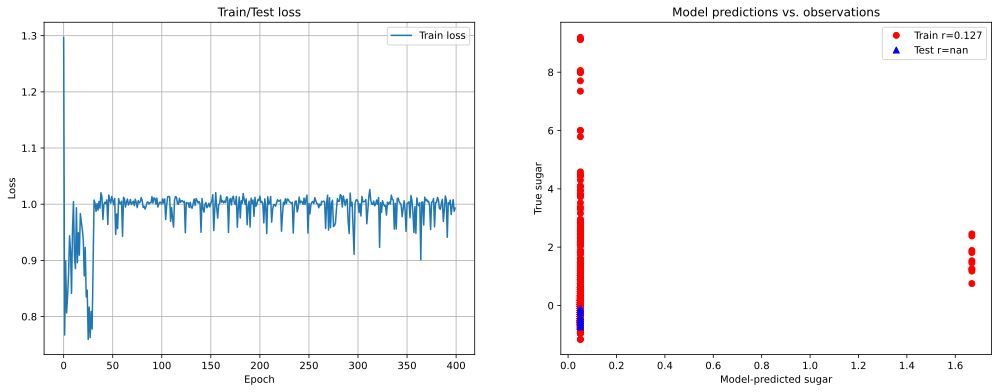

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))

ax[0].plot(trainLoss, label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yhatTrain.detach(), train_labelT, 'ro')
ax[1].plot(yhatTest.detach(), test_labelT, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yhatTrain.detach().T, train_labelT.T)[1,0]
corrTest  = np.corrcoef(yhatTest.detach().T, test_labelT.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}'])

plt.show()

In [ ]:
# import the data
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

# z-score all columns
data = (data - data.mean())/data.std(ddof=1)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy( data )

In [ ]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan
# (note: in the video I don't have replace=False, which means it's possible to select the same values twice)
whichVals2nan = np.random.choice(range(len(data)),size=n2nan,replace=False)

# set those values to be nan (safe to ignore the overwrite warning)
data['residual sugar'][whichVals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

# confirm
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 273  355  460  550 1095 1107 1141 1237 1288 1536]
[ 273  355  460  550 1095 1107 1141 1237 1288 1536]


In [ ]:
# convert from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

# extract dataframe to TRAIN tensors
train_dataT  = torch.tensor( data[cols2keep].values ).float()
train_dataT  = train_dataT[whichValsNotNan,:]
train_labelT = torch.tensor( data['residual sugar'].values ).float()
train_labelT = train_labelT[whichValsNotNan,None] # the 'None' is transform to matrix


# same for TEST tensors
test_dataT  = torch.tensor( dataOrig[cols2keep].values ).float()
test_dataT  = test_dataT[whichVals2nan,:]
test_labelT = torch.tensor( dataOrig['residual sugar'].values ).float()
test_labelT = test_labelT[whichVals2nan,None] # the 'None' is transform to matrix

# confirm sizes
print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelT.shape}')

Original data: (1599, 12)

   Train data: torch.Size([1589, 11])

 Train labels: torch.Size([1589, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [ ]:
# then convert them into PyTorch Dataset
train_dataDataset = TensorDataset(train_dataT,train_labelT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 400

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_data:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

  # function output
  return trainLoss

In [ ]:
# create a model and train it
winenet = ANNwine()
trainLoss = trainTheModel()

In [ ]:
# get the predictions for the missing data
yHatTrain = winenet(train_dataT)
yHatTest  = winenet(test_dataT)

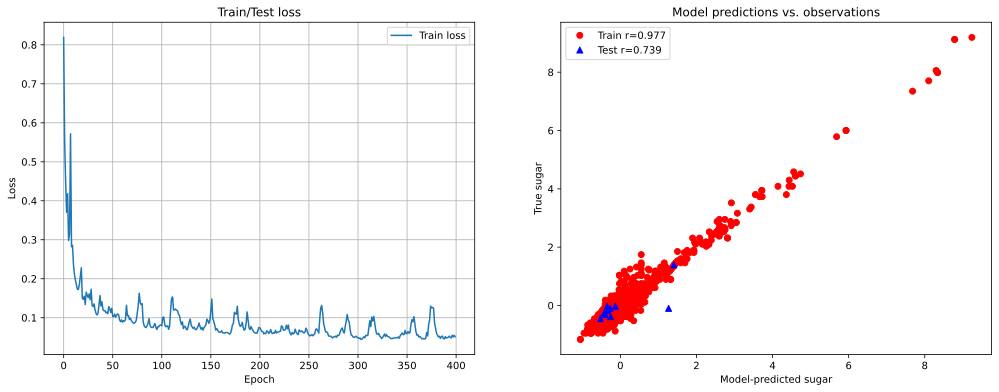

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yHatTrain.detach(),train_labelT,'ro')
ax[1].plot(yHatTest.detach(),test_labelT,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelT.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()